# EPFL_Migros: Library Recommender System

## Version 1: Collaborative Filtering (baseline)

**Data Cleaning and EDA**

In [ ]:
#import packages
import numpy as np
import pandas as pd
import sklearn
import re
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#import data
filepath='https://raw.githubusercontent.com/fedeamedeo/machine-learning-project/main/Data/'
interactions = pd.read_csv(filepath + 'interactions_train.csv')
items=pd.read_csv(filepath + 'items.csv')

In [ ]:
#display data
display(interactions.head())
display(items.head())

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [ ]:
#check for duplicates in the interactions df
duplicates = interactions.duplicated()

#count number of duplicate rows
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows in interactions: {num_duplicates}")

#display duplicate rows if any
if num_duplicates > 0:
    print("Duplicate rows:")
    print(interactions[duplicates])

Number of duplicate rows in interactions: 2
Duplicate rows:
          u      i             t
6103   7210  12290  1.718023e+09
44025  1323  10037  1.700055e+09


In [ ]:
#drop duplicates
interactions = interactions.drop_duplicates()

# verify the shape after dropping duplicates
print(f"Shape after dropping duplicates: {interactions.shape}")

Shape after dropping duplicates: (87045, 3)


Basic Statistics:
Number of unique users: 7838
Number of unique items: 15109
Time range: 1672663643.0 to 1728925054.0


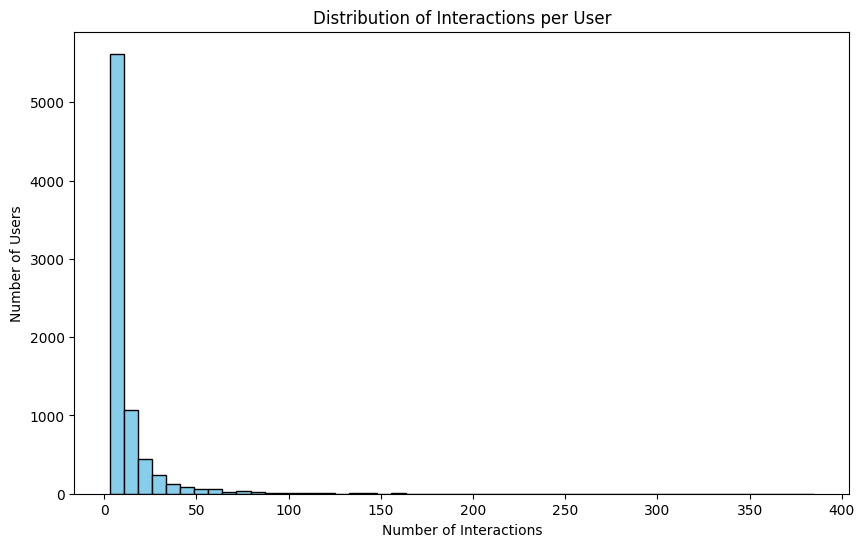

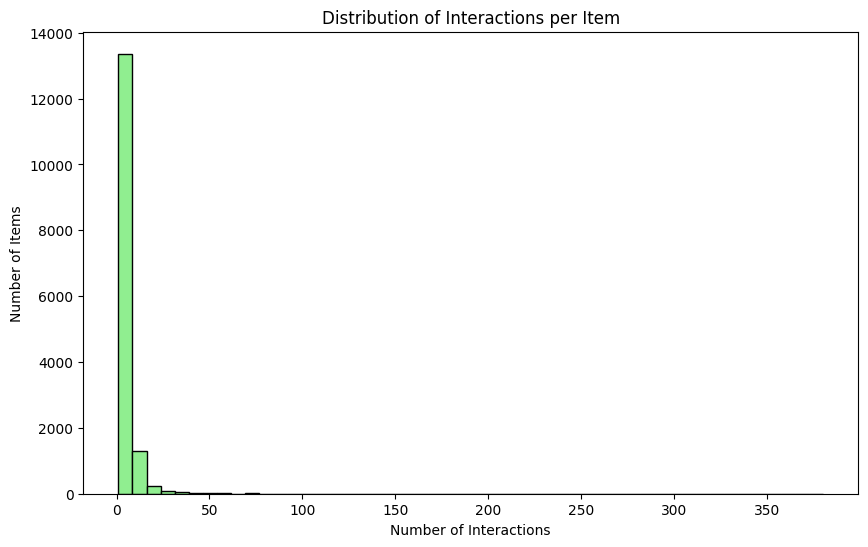

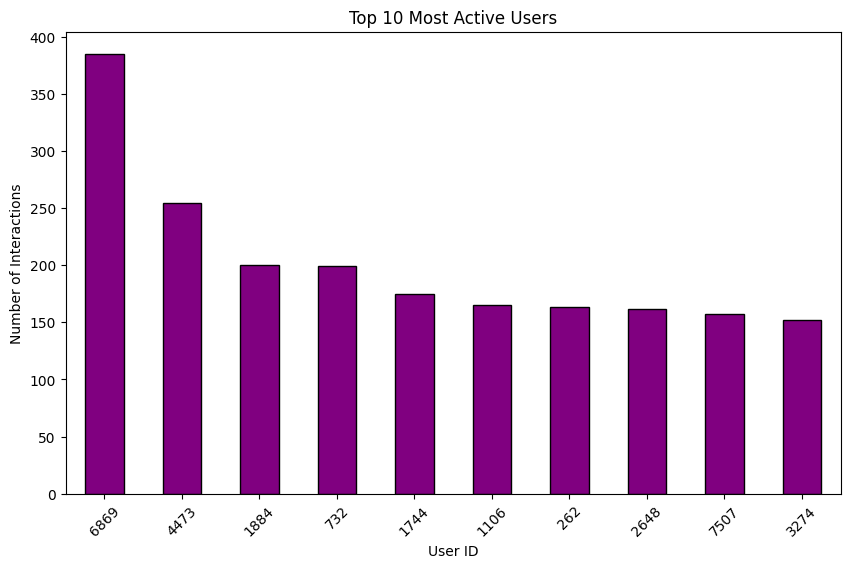

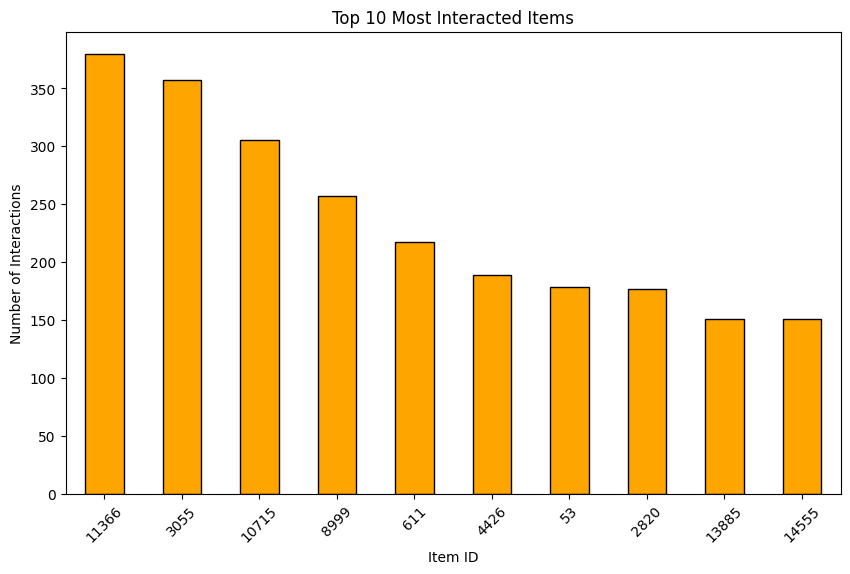

In [ ]:
# basic statistics
print("Basic Statistics:")
print(f"Number of unique users: {interactions['u'].nunique()}")
print(f"Number of unique items: {interactions['i'].nunique()}")
print(f"Time range: {interactions['t'].min()} to {interactions['t'].max()}")

#interactions per user
user_interactions = interactions['u'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(user_interactions, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

#interactions per item
item_interactions = interactions['i'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(item_interactions, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Interactions per Item')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Items')
plt.show()

#top users and items
top_users = user_interactions.head(10)
plt.figure(figsize=(10, 6))
top_users.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Top 10 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()

top_items = item_interactions.head(10)
plt.figure(figsize=(10, 6))
top_items.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Most Interacted Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()


<ipython-input-16-f1ef94a494ff>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')


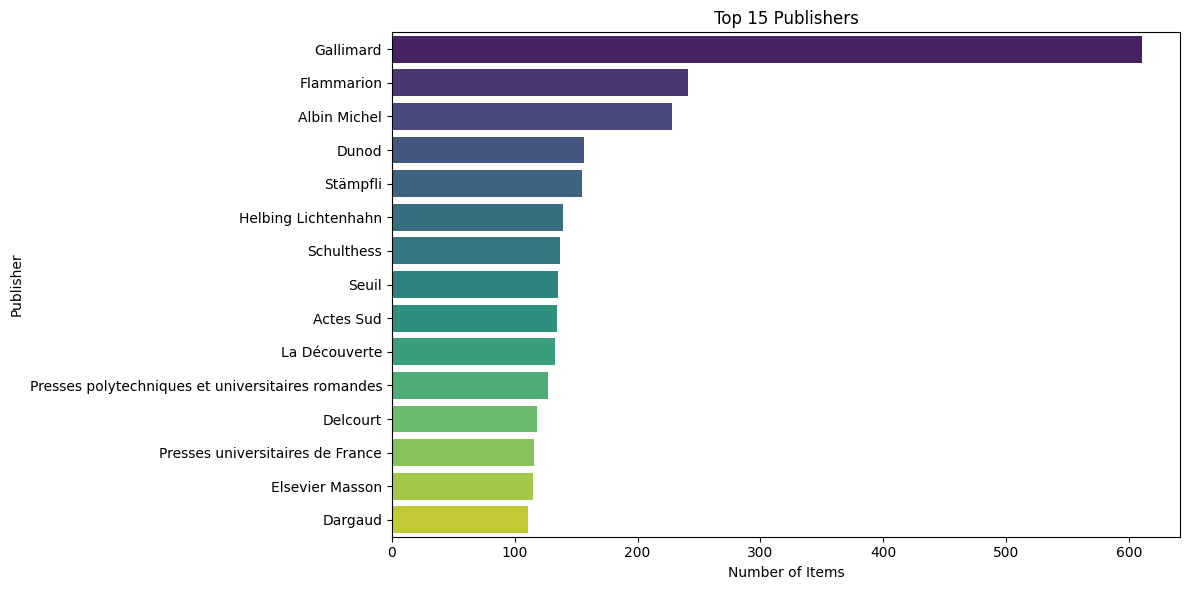

<ipython-input-16-f1ef94a494ff>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.values, y=author_counts.index, palette='coolwarm')


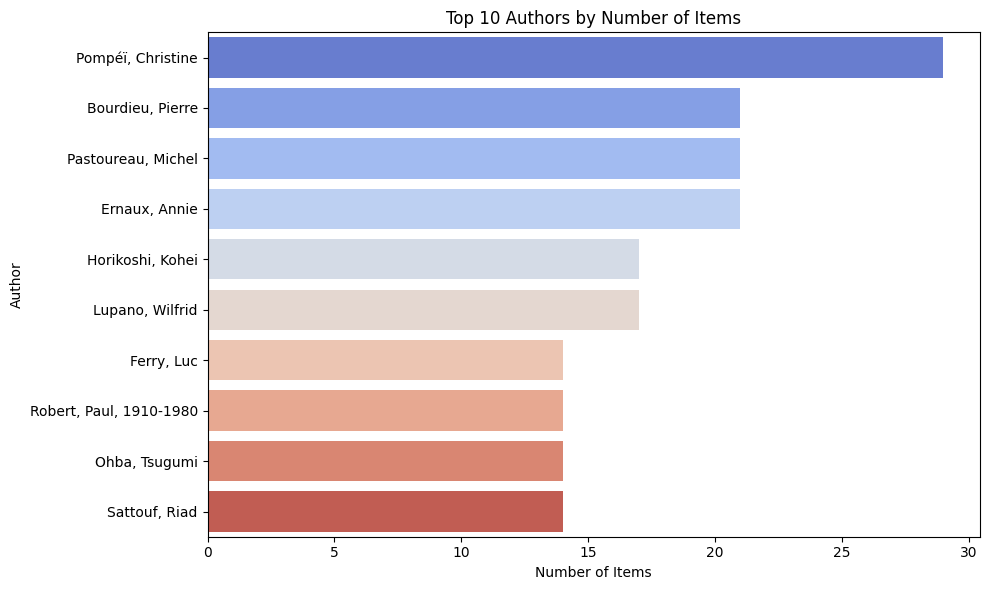

<ipython-input-16-f1ef94a494ff>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='mako')


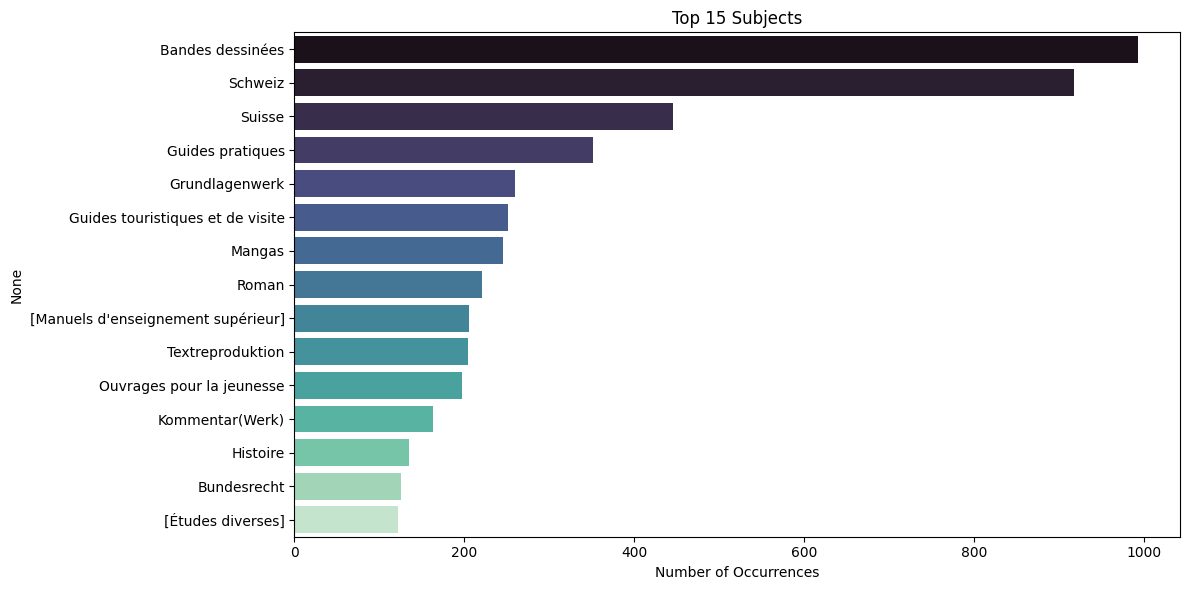

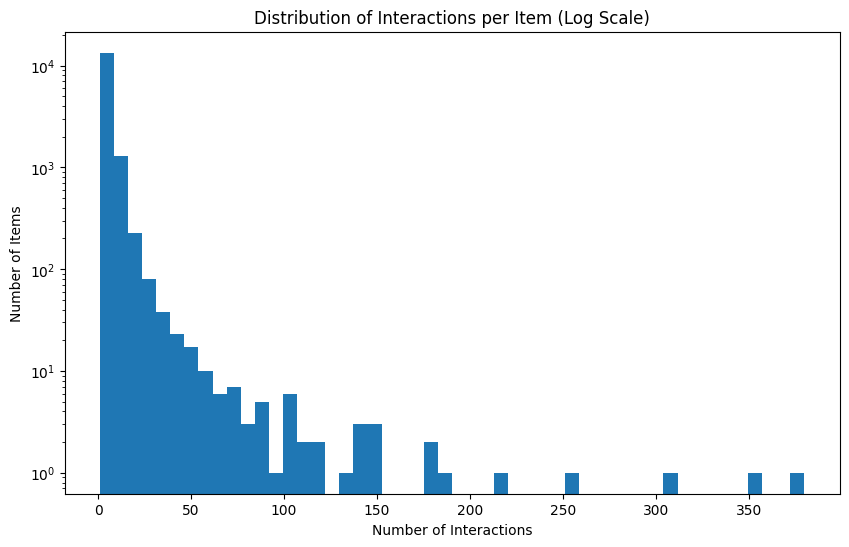

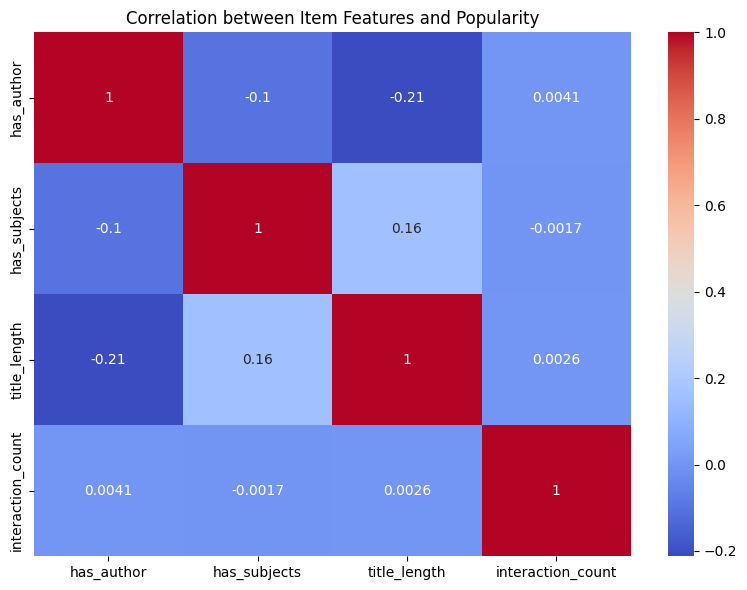

In [ ]:
#distribution of publishers
plt.figure(figsize=(12, 6))
top_publishers = items['Publisher'].value_counts().head(15)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')
plt.title('Top 15 Publishers')
plt.xlabel('Number of Items')
plt.tight_layout()
plt.show()

#author analysis
plt.figure(figsize=(10, 6))
author_counts = items['Author'].value_counts().head(10)
sns.barplot(x=author_counts.values, y=author_counts.index, palette='coolwarm')
plt.title('Top 10 Authors by Number of Items')
plt.xlabel('Number of Items')
plt.tight_layout()
plt.show()

#subject analysis
#extract and count subjects (handling multiple subjects per item)
interactions_with_items=pd.merge(interactions, items, on='i') #merge with metadata
all_subjects = []
for subjects in items['Subjects'].dropna():
    subject_list = str(subjects).split(';')
    all_subjects.extend([subj.strip() for subj in subject_list])

subject_counts = pd.Series(all_subjects).value_counts()
plt.figure(figsize=(12, 6))
top_subjects = subject_counts.head(15)
sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='mako')
plt.title('Top 15 Subjects')
plt.xlabel('Number of Occurrences')
plt.tight_layout()
plt.show()

#analyze book popularity based on interactions
if 'interactions' in globals():
    plt.figure(figsize=(10, 6))

    #reset the index of value_counts to create a dataframe
    item_interaction_counts = interactions['i'].value_counts().reset_index()
    item_interaction_counts.columns = ['i', 'count']  # rename columns for clarity

    #plot the distribution of interactions
    interactions_with_items['interaction_count']= interactions_with_items['i'].value_counts()
    plt.hist(interactions_with_items['interaction_count'], bins=50, log=True)
    plt.title('Distribution of Interactions per Item (Log Scale)')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Items')
    plt.show()

    #correlation between metadata and popularity
    #create indicator for having author information
    interactions_with_items['has_author'] = interactions_with_items['Author'].notna().astype(int)
    interactions_with_items['has_subjects'] = interactions_with_items['Subjects'].notna().astype(int)

    #create title length feature
    interactions_with_items['title_length'] = interactions_with_items['Title'].str.len()

    #analyze correlation with popularity
    features = ['has_author', 'has_subjects', 'title_length']
    corr = interactions_with_items[features + ['interaction_count']].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation between Item Features and Popularity')
    plt.tight_layout()
    plt.show()

Missing values in items dataset:
i                    0
Title                0
Author            1297
ISBN Valid         723
Publisher           23
Subjects          1763
content              0
clean_text_min       0
popularity           0
dtype: int64

Percentage of missing values in items dataset:
i                  0.00
Title              0.00
Author             8.48
ISBN Valid         4.73
Publisher          0.15
Subjects          11.53
content            0.00
clean_text_min     0.00
popularity         0.00
dtype: float64


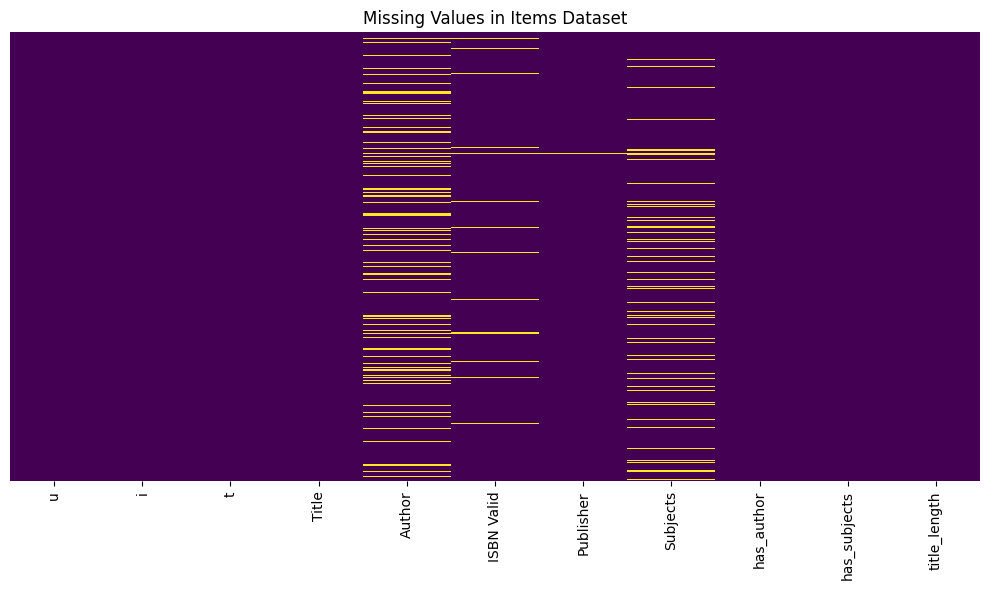

In [ ]:
# Analyzing missing values in the datasets
print("Missing values in items dataset:")
missing_items = items.isnull().sum()
print(missing_items)
print("\nPercentage of missing values in items dataset:")
print((missing_items / len(items) * 100).round(2))

# Visualizing missing data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
interactions_with_items = interactions_with_items.drop(columns=['interaction_count'])
sns.heatmap(interactions_with_items.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values in Items Dataset')
plt.tight_layout()
plt.show()

**Train/test split**

In [ ]:
n_users = interactions.u.nunique()
n_items = items.i.nunique()

In [ ]:
interactions = interactions.sort_values(["u", "t"])

In [ ]:
interactions["pct_rank"] = interactions.groupby("u")["t"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)
interactions.head(10)

,u,i,t,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [ ]:
train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]

In [ ]:
#define a function to create the data matrix
def create_data_matrix(data, n_users, n_items):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data["u"].values, data["i"].values] = 1
    return data_matrix

In [ ]:
#create the training and testing matrices
train_data_matrix = create_data_matrix(train_data, n_users, n_items)
test_data_matrix = create_data_matrix(test_data, n_users, n_items)

#display the matrices to understand their structure
print('train_data_matrix')
print(train_data_matrix)
print("number of non-zero values: ", np.sum(train_data_matrix))
print('test_data_matrix')
print(test_data_matrix)
print("number of non-zero values: ", np.sum(test_data_matrix))

train_data_matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  49689.0
test_data_matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  19409.0


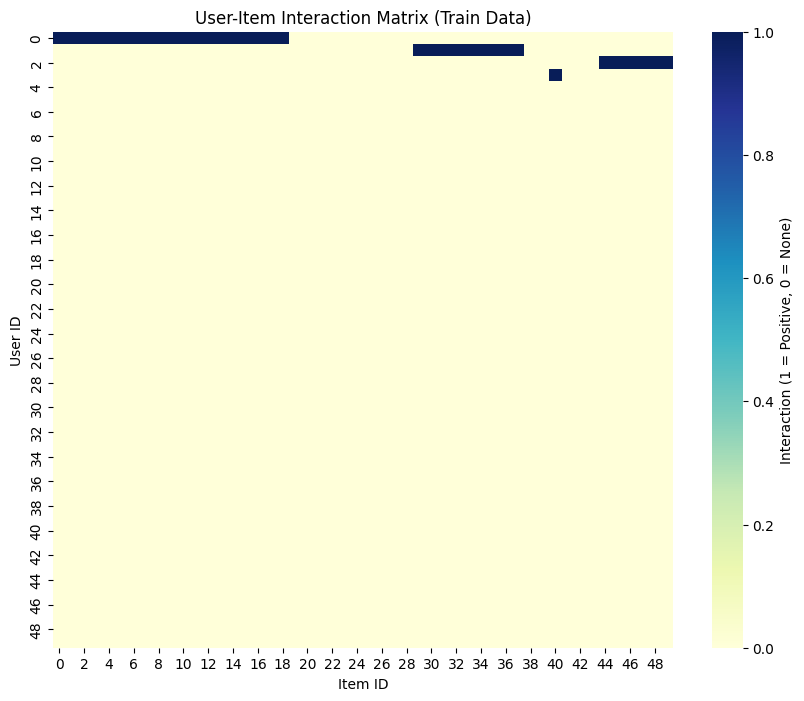

In [ ]:
#function to plot a heatmap for a subset of the user-item matrix
def plot_interaction_heatmap(data_matrix, title, num_users=1000, num_items=1000):
    """
    Plots a heatmap of a subset of the user-item interaction matrix.
    Parameters:
        data_matrix: The matrix to visualize.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    #extract a subset of the matrix for visualization purposes
    matrix_subset = data_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

#visualize a subset of the training and testing matrices
plot_interaction_heatmap(train_data_matrix, 'User-Item Interaction Matrix (Train Data)')


**Item-based Collaborative Filtering**

In [ ]:
#compute the item-item similarity matrix
item_similarity = cosine_similarity(train_data_matrix.T)
print("Item-Item Similarity Matrix:")
print(item_similarity)
print(item_similarity.shape)

Item-Item Similarity Matrix:
[[1.         0.40824829 0.33333333 ... 0.         0.         0.        ]
 [0.40824829 1.         0.40824829 ... 0.         0.         0.        ]
 [0.33333333 0.40824829 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
(15291, 15291)


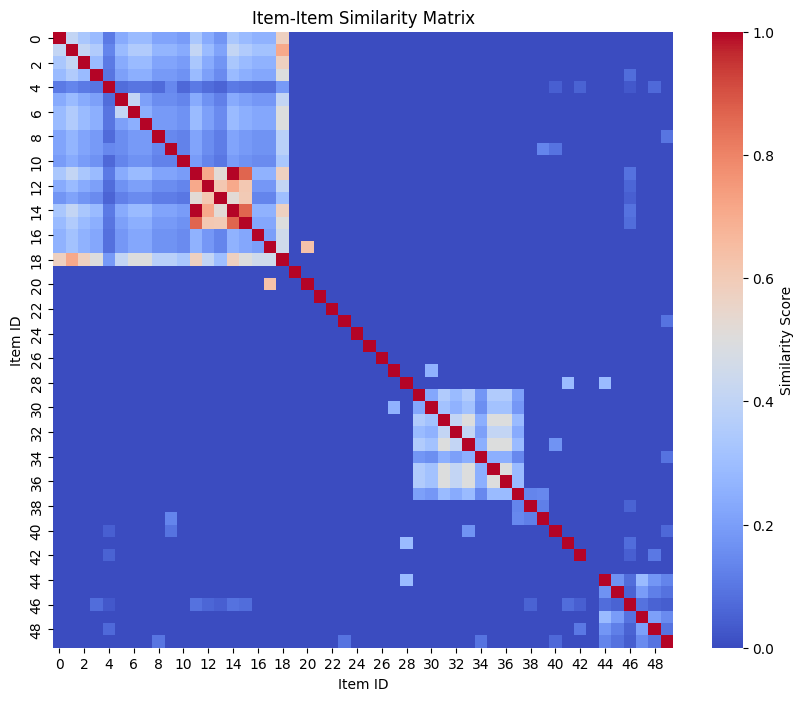

In [ ]:
#function to visualize the item similarity matrix
def plot_item_similarity_heatmap(similarity_matrix, title, num_items=50):
    """
    Plots a heatmap of a subset of the item similarity matrix.
    Parameters:
        similarity_matrix: The item-item similarity matrix.
        title: The title of the plot.
        num_items: The number of items to display (both rows and columns).
    """
    #extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_items, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('Item ID')
    plt.ylabel('Item ID')
    plt.title(title)
    plt.show()

#visualize a subset of the item similarity matrix
plot_item_similarity_heatmap(item_similarity, 'Item-Item Similarity Matrix')

In [ ]:
#define the function to predict interactions based on item similarity
def item_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on item-item similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The item-item similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    pred = similarity.dot(interactions.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T  #transpose to get users as rows and items as columns

In [ ]:
#calculate the item-based predictions for positive interactions
item_prediction = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interaction Matrix:")
print(item_prediction)
print(item_prediction.shape)

Predicted Interaction Matrix:
[[0.46097255 0.85435984 0.71867834 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15291)


**User-based Collaborative Filtering**

In [ ]:
#compute the user-user similarity matrix
user_similarity = cosine_similarity(train_data_matrix)
print("User-User Similarity Matrix:")
print(user_similarity)

#check the shape as a sanity check
print("Shape of User Similarity Matrix:", user_similarity.shape)

User-User Similarity Matrix:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Shape of User Similarity Matrix: (7838, 7838)


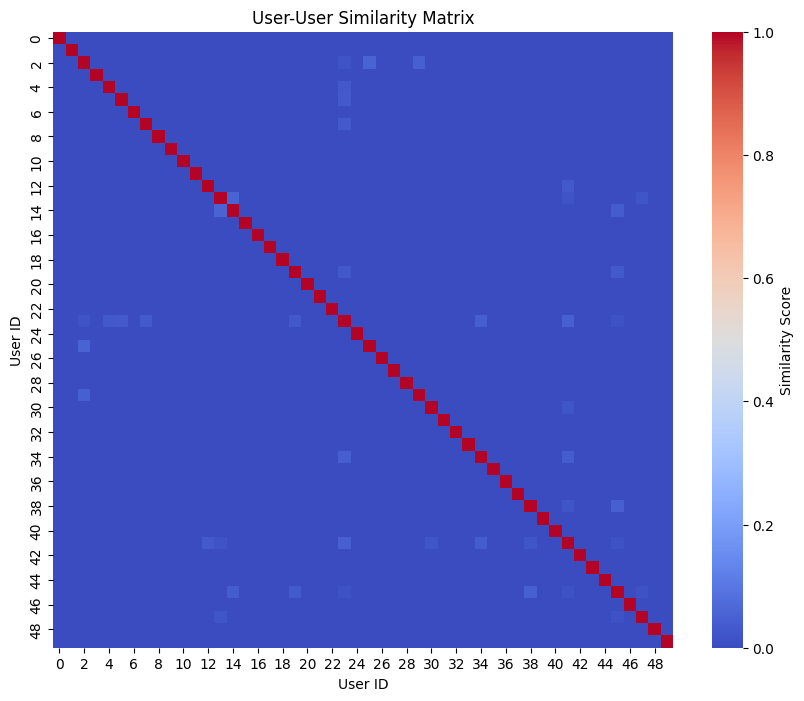

In [ ]:
#function to plot the user similarity matrix
def plot_user_similarity_heatmap(similarity_matrix, title, num_users=50):
    """
    Plots a heatmap of a subset of the user similarity matrix.
    Parameters:
        similarity_matrix: The user-user similarity matrix.
        title: The title of the plot.
        num_users: The number of users to display (both rows and columns).
    """
    #extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_users, :num_users]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('User ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the user similarity matrix
plot_user_similarity_heatmap(user_similarity, 'User-User Similarity Matrix')

In [ ]:
#define the function to predict interactions based on user similarity
def user_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on user-user similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The user-user similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    #calculate the weighted sum of interactions based on user similarity
    pred = similarity.dot(interactions) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred

#calculate the user-based predictions for positive interactions
user_prediction = user_based_predict(train_data_matrix, user_similarity)
print("Predicted Interaction Matrix (User-Based):")
print(user_prediction)
print(user_prediction.shape)

Predicted Interaction Matrix (User-Based):
[[0.13171649 0.13259591 0.14274867 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15291)


**Evaluating the Recommenders**

In [ ]:
#function to compute MAP@10
def MAP10(predictions, ground_truth, k=10):
    map_at_k = 0
    n_users = predictions.shape[0]
    for user in range(n_users):
        predicted_ranks = np.argsort(predictions[user])[::-1][:k]
        true_items = np.where(ground_truth[user] == 1)[0]
        hits = 0
        sum_precisions = 0
        for i, item in enumerate(predicted_ranks):
            if item in true_items:
                hits += 1
                sum_precisions += hits / (i + 1)
        map_at_k += sum_precisions / min(len(true_items), k) if len(true_items) > 0 else 0
    return map_at_k / n_users

In [ ]:
print(f"MAP@10 of user_based CF: {MAP10(user_prediction, test_data_matrix)}")
print(f"MAP@10 of item_based CF: {MAP10(item_prediction, test_data_matrix)}")

MAP@10 of user_based CF: 0.17995137089973404
MAP@10 of item_based CF: 0.16318858262001948


In [27]:
#defining the function for precision and recall @K
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0

    for user in range(num_users):
        #get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]

        #calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.isin(top_k_items, np.where(ground_truth[user, :] == 1)[0]).sum()

        #calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()

        #precision@K and recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

    #average precision@K and recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users

    return precision_at_k, recall_at_k

In [ ]:
#precision and recall @k for user- and item-based CF
precision_user_k, recall_user_k = precision_recall_at_k(user_prediction, test_data_matrix, k=10)
precision_item_k, recall_item_k = precision_recall_at_k(item_prediction, test_data_matrix, k=10)

print('User-based CF Precision10:', precision_user_k)
print('User-based CF Recall@10:', recall_user_k)
print('Item-based CF Precision@10:', precision_item_k)
print('Item-based CF Recall@10:', recall_item_k)

User-based CF Precision@K: 0.05651952028578993
User-based CF Recall@K: 0.2904852348772922
Item-based CF Precision@K: 0.05565195202858152
Item-based CF Recall@K: 0.26401457990923116


## Version 2: Metadata Enhancement and Text Embeddings

In [ ]:
#API metadata enhancement using Google Books and Open Library as fallback
import requests
import time
from tqdm.notebook import tqdm

#copy original items table
items_improved = items.copy()

#extract first valid ISBN from a semicolon-separated field
def extract_first_isbn(isbn_field):
    if pd.isna(isbn_field):
        return None
    isbn_list = str(isbn_field).split(';')
    if len(isbn_list) > 0:
        isbn = ''.join(c for c in isbn_list[0].strip() if c.isdigit())
        return isbn
    return None

#fetch metadata from Google Books API
def fetch_book_metadata_google(isbn):
    url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            items = data.get("items", [])
            if items:
                info = items[0].get("volumeInfo", {})
                author = info.get("authors", [None])[0]
                publisher = info.get("publisher")
                subject = info.get("categories", [None])[0]
                return author, publisher, subject
    except Exception as e:
        print(f"Google Books error for ISBN {isbn}: {e}")
    return None, None, None

#fetch metadata from Open Library API
def fetch_book_metadata_openlibrary(isbn):
    url = f"https://openlibrary.org/isbn/{isbn}.json"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            author = None
            if "authors" in data and data["authors"]:
                author_key = data["authors"][0]["key"]
                auth_response = requests.get(f"https://openlibrary.org{author_key}.json")
                if auth_response.status_code == 200:
                    author = auth_response.json().get("name")
            publisher = data.get("publishers", [None])[0]
            subject = data.get("subjects", [None])[0] if data.get("subjects") else None
            return author, publisher, subject
    except Exception as e:
        print(f"Open Library error for ISBN {isbn}: {e}")
    return None, None, None

#identify rows with missing author or subjects and valid ISBN
missing_data = items_improved[
    (items_improved['Author'].isna() | items_improved['Subjects'].isna()) &
    (~items_improved['ISBN Valid'].isna())
]

print(f"\nBooks needing metadata: {len(missing_data)}")

successful_fetches = 0

for idx in tqdm(missing_data.index):
    isbn = extract_first_isbn(items_improved.at[idx, 'ISBN Valid'])
    if not isbn:
        continue

    need_author = pd.isna(items_improved.at[idx, 'Author'])
    need_subject = pd.isna(items_improved.at[idx, 'Subjects'])
    need_publisher = pd.isna(items_improved.at[idx, 'Publisher'])

    #first try Google Books
    author, publisher, subject = fetch_book_metadata_google(isbn)

    #ff not found, try Open Library
    if not author and not subject and not publisher:
        author, publisher, subject = fetch_book_metadata_openlibrary(isbn)

    if author and need_author:
        items_improved.at[idx, 'Author'] = author
        successful_fetches += 1

    if subject and need_subject:
        items_improved.at[idx, 'Subjects'] = subject
        successful_fetches += 1

    if publisher and need_publisher:
        items_improved.at[idx, 'Publisher'] = publisher

    time.sleep(0.1)  # Respect API rate limits

#final fallback for truly missing values
items_improved['Author'].fillna("Unknown Author", inplace=True)
items_improved['Subjects'].fillna("Uncategorized", inplace=True)
items_improved['Publisher'].fillna("Unknown Publisher", inplace=True)
items_improved['ISBN Valid'].fillna("Not Available", inplace=True)

#print results
print(f"\nSuccessful metadata fetches: {successful_fetches}")
print("Remaining missing values:")
print(items_improved.isnull().sum())

#merge back with interaction data
interactions_with_items_improved = interactions.merge(items_improved, on='i', how='left')
print("\nSample of enhanced data:")
print(interactions_with_items_improved.sample(5))


In [ ]:
#create text embeddings
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Load book metadata
items['content'] = items['Title'].fillna('') + ' ' + \
                   items['Author'].fillna('') + ' ' + \
                   items['Subjects'].fillna('') + ' ' + \
                   items['Publisher'].fillna('')

In [ ]:
item_embeddings = model.encode(items['content'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/478 [00:00<?, ?it/s]

In [ ]:
#compute user profile embeddings
def compute_user_profiles(train_data_matrix, item_embeddings):
    n_users = train_data_matrix.shape[0]
    embedding_dim = item_embeddings.shape[1]
    user_profiles = np.zeros((n_users, embedding_dim))

    for user_id in range(n_users):
        interacted_items = np.where(train_data_matrix[user_id] > 0)[0]
        if len(interacted_items) > 0:
            user_profiles[user_id] = item_embeddings[interacted_items].mean(axis=0)
        else:
            # Optional: handle cold-start users by using the mean embedding or zeros
            user_profiles[user_id] = np.zeros(embedding_dim)

    return user_profiles

In [ ]:
#compute similarity between user profiles and all item embeddings
def predict_scores(user_profiles, item_embeddings):
    return cosine_similarity(user_profiles, item_embeddings)

In [ ]:
#generate top-10 recommendations
def generate_top_n_recommendations(score_matrix, top_n=10):
    recommendations = []
    for user_id in range(score_matrix.shape[0]):
        top_items = np.argsort(score_matrix[user_id])[::-1][:top_n]
        recommendations.append([user_id, " ".join(map(str, top_items))])
    return recommendations
user_profiles = compute_user_profiles(train_data_matrix, item_embeddings)
score_matrix = predict_scores(user_profiles, item_embeddings)
recommendations = generate_top_n_recommendations(score_matrix, top_n=10)

In [ ]:
#computing MAP@10
print(f"MAP@10 Embeddings: {MAP10(score_matrix, test_data_matrix)}")

MAP@10 Embeddings: 0.1531791887816337


In [28]:
#precision@10 and recall@10
precision_user_k, recall_user_k = precision_recall_at_k(score_matrix, test_data_matrix, k=10)
precision_item_k, recall_item_k = precision_recall_at_k(score_matrix, test_data_matrix, k=10)

print('Embeddings Precision10:', precision_user_k)
print('Embeddings Recall@10:', recall_user_k)

Embeddings Precision10: 0.03864506251594793
Embeddings Recall@10: 0.23851758609316576


## Version 3: Hybrid Model (CF and Embeddings)

In [ ]:
#creating the user embeddings
train_histories = train_data.groupby("u")["i"].apply(list).to_dict()
user_embeddings = np.zeros((n_users, item_embeddings.shape[1]))

for user_id, item_ids in train_histories.items():
    valid_items = [i for i in item_ids if i < len(item_embeddings)]
    if valid_items:
        user_embeddings[user_id] = np.mean(item_embeddings[valid_items], axis=0)

In [ ]:
#compute embeddings similarity scores
cb_scores = cosine_similarity(user_embeddings, item_embeddings)

In [ ]:
#collaborative filtering predictions
item_similarity = cosine_similarity(train_data_matrix.T)

def item_based_predict(interactions, similarity, epsilon=1e-9):
    pred = similarity.dot(interactions.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T

cf_scores = item_based_predict(train_data_matrix, item_similarity)

In [ ]:
#hybrid scores
from sklearn.preprocessing import MinMaxScaler

def normalize_scores(matrix):
    scaler = MinMaxScaler()
    return scaler.fit_transform(matrix)

normalized_cb = normalize_scores(cb_scores)
normalized_cf = normalize_scores(cf_scores)
min_items = min(normalized_cb.shape[1], normalized_cf.shape[1])
normalized_cb = normalized_cb[:, :min_items]
normalized_cf = normalized_cf[:, :min_items]
assert normalized_cb.shape == normalized_cf.shape

alpha = 1
#for a in np.linspace(0, 1, 11):
    #hybrid = a * normalized_cf + (1 - a) * normalized_cb
    #score = mean_average_precision_at_k(hybrid, test_data_matrix)
    #print(f"alpha={a:.1f}, MAP@10={score:.4f}")
hybrid_scores = alpha * normalized_cf + (1 - alpha) * normalized_cb


In [ ]:
#evaluate our recommender
print("Hybrid MAP@10:", MAP10(hybrid_scores, test_data_matrix))

Hybrid MAP@10: 0.17935114409896888


## Version 4: TF-IDF

In [ ]:
filepath='https://raw.githubusercontent.com/fedeamedeo/machine-learning-project/main/Data/'
interactions = pd.read_csv(filepath + 'interactions_train.csv')
filepath='https://raw.githubusercontent.com/fedeamedeo/machine-learning-project/main/'
items1= pd.read_csv(filepath+'items_improved.csv')
filepath='https://raw.githubusercontent.com/fedeamedeo/machine-learning-project/main/Data/'
items2 = pd.read_csv(filepath+'items_enriched_openlibrary.csv')

In [ ]:
# Set index to align rows by book ID
items1 = items.set_index('i')
items2 = items2.set_index('i')

# Fill missing values in `items` using values from `items_sana`
items1.update(items2)
items=items1

# Reset index if needed
items = items.reset_index()

In [ ]:
# Load book metadata
items['content'] = items['Title'].fillna('') + ' ' + \
                   items['Author'].fillna('') + ' ' + \
                   items['Subjects'].fillna('') + ' ' + \
                   items['Publisher'].fillna('')

In [ ]:
#minimal pre-processing
def clean_minimal(text):
    return re.sub(r"[^\w\s]", " ", str(text).lower())

In [ ]:
items["clean_text_min"] = items["content"].fillna("").apply(clean_minimal)

In [ ]:
# Add popularity boost
item_popularity = interactions['i'].value_counts(normalize=True)
items['popularity'] = items['i'].map(item_popularity).fillna(0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Download French stopwords if not already
import nltk
nltk.download('stopwords')

# Load French stopwords as a list
french_stopwords = stopwords.words('french')

vectorizer = TfidfVectorizer(stop_words=french_stopwords, max_features=1000000, sublinear_tf=True, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(items['clean_text_min'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from scipy.sparse import csr_matrix

# Merge interactions and items to match on 'i'
merged = interactions.merge(items[['i']], on='i')

# Create a user profile: mean of TF-IDF vectors of books they've interacted with
user_profiles = {}
for user_id, group in merged.groupby('u'):
    indices = group['i'].values
    profile = tfidf_matrix[indices].mean(axis=0).A1
    user_profiles[user_id] = profile

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

recommendations = []

for user_id, profile in user_profiles.items():
    # Reshape profile to ensure compatibility with tfidf_matrix
    sims = cosine_similarity(profile.reshape(1, -1), tfidf_matrix).flatten()
    boosted_sims = sims + 0.01 * items['popularity'].values
    top_indices = np.argsort(-boosted_sims)[:10]
    #top_indices = np.argsort(-sims)[:10]  # top 10
    book_ids = items.iloc[top_indices]['i'].tolist()
    recommendations.append((user_id, book_ids))

In [ ]:
 tfidf_sims2=cosine_similarity(tfidf_matrix)

In [ ]:
def MAP10(predictions, ground_truth, k=10):
    """
    Calculates Mean Average Precision at k (MAP@k).
    """
    map_at_k = 0
    # n_users should be the number of users in the ground_truth (test_data_matrix)
    n_users = ground_truth.shape[0]
    for user in range(n_users):
        predicted_ranks = np.argsort(predictions[user])[::-1][:k]
        true_items = np.where(ground_truth[user] == 1)[0]
        hits = 0
        sum_precisions = 0
        for i, item in enumerate(predicted_ranks):
            if item in true_items:
                hits += 1
                sum_precisions += hits / (i + 1)
        map_at_k += sum_precisions / min(len(true_items), k) if len(true_items) > 0 else 0
    return map_at_k / n_users

In [ ]:
print(f"MAP@10 of TF-IDF: {MAP10(tfidf_sims2, test_data_matrix)}")

MAP@10 of TF-IDF: 0.00012788607192472975


In [ ]:
import csv

with open("tf_idf.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["user_id", "recommendation"])
    for user_id, book_ids in recommendations:
        writer.writerow([user_id, " ".join(map(str, book_ids))])

In [ ]:
from google.colab import files
files.download('tf_idf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>